In [ ]:
!pip install statsmodels --upgrade
!pip install yfinance

All available NASDAQ listings: 
   Symbol                                       Company Name  \
0   AAIT  iShares MSCI All Country Asia Information Tech...   
1    AAL                      American Airlines Group, Inc.   
2   AAME                      Atlantic American Corporation   
3   AAOI                      Applied Optoelectronics, Inc.   
4   AAON                                         AAON, Inc.   

                                       Security Name Market Category  \
0  iShares MSCI All Country Asia Information Tech...               G   
1       American Airlines Group, Inc. - Common Stock               Q   
2       Atlantic American Corporation - Common Stock               G   
3       Applied Optoelectronics, Inc. - Common Stock               G   
4                          AAON, Inc. - Common Stock               Q   

  Test Issue Financial Status  Round Lot Size  
0          N                N           100.0  
1          N                N           100.0  
2          

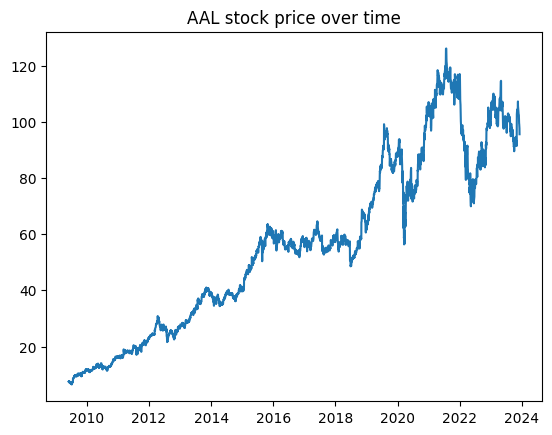

In [ ]:
"""
No need to change this block - loads dataset and necessary packages
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import yfinance as yf

url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content

companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
print("All available NASDAQ listings: \n", companies.head())

fb_series = yf.download("SBUX",start='2009-06-01',progress=False)
print("Sample of ADMS stock series: \n", fb_series.head())

price = fb_series.reset_index()['Close'].values.reshape(-1,1)
date = fb_series.reset_index().Date.dt.date.values.reshape(-1,1)
plt.plot(date, price)
plt.title("AAL stock price over time")
plt.show()

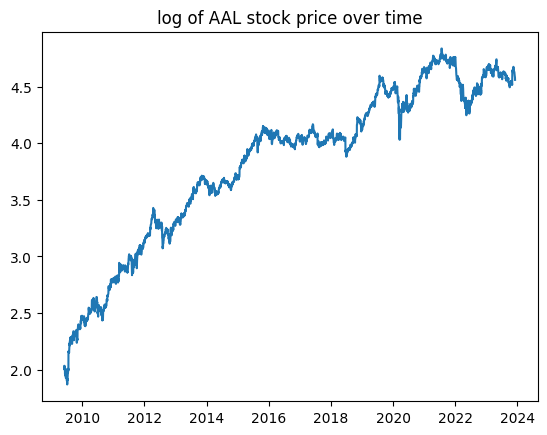

In [ ]:
# Applying log transformation
log_price = np.log(price)
plt.plot(date, log_price)
plt.title("log of AAL stock price over time")
plt.show()

In [ ]:
# Example here about how to find; what my assumption is behind this
from scipy.stats import norm
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and
  the residuals of the model. Assumes residuals are distributed
  Gaussian with unknown variance.
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and
  the residuals of the model. Assumes residuals are distributed
  Gaussian with unknown variance.
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

### Start with a linear model:

[[0.00062746]]


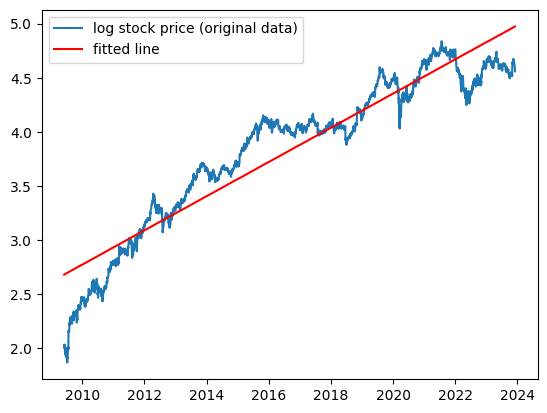

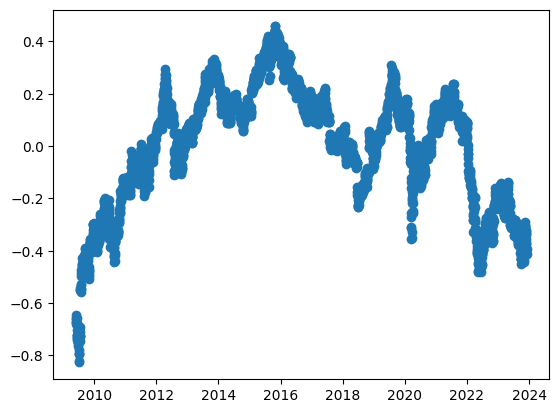

MSE with linear fit: 0.05189300578428731
AIC: -439.13728196062584
BIC: -432.933430588442


In [ ]:

from sklearn import linear_model
clf = linear_model.LinearRegression()
index = fb_series.reset_index().index.values.reshape(-1,1)

clf.fit(index, log_price)
print(clf.coef_) # To print the coefficient estimate of the series.
linear_prediction = clf.predict(index)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = log_price - linear_prediction
plt.plot(date, linear_residuals, 'o')
plt.show();
print("MSE with linear fit:", np.mean((linear_residuals)**2))
print("AIC:", evaluate_AIC(1, linear_residuals))
print("BIC:", evaluate_BIC(1, linear_residuals))

### After linear fit, it seems like a higher order model is needed

[[ 1.30622404e-03 -1.85758157e-07]]


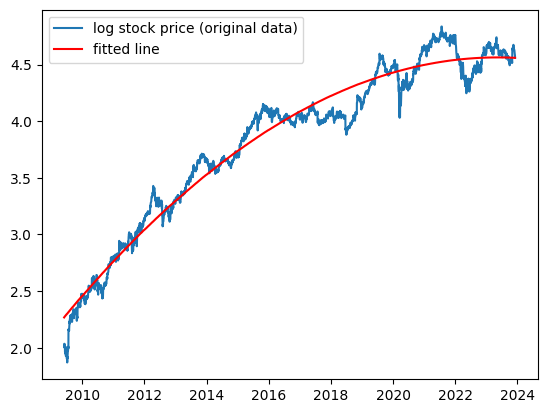

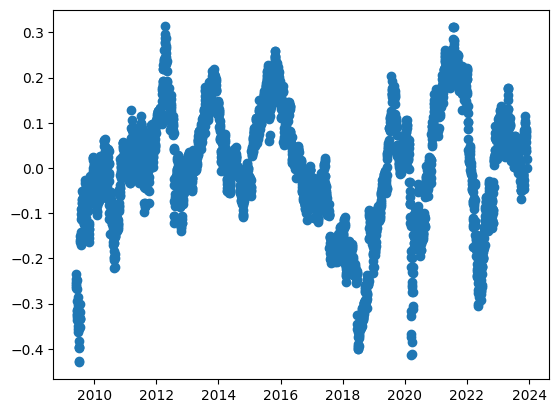

MSE with quadratic fit: 0.017681464026014095
AIC: -4372.355741159218
BIC: -4359.94803841485


In [ ]:
## After linear fit, it seems like a higher order model is needed
from sklearn import linear_model
clf = linear_model.LinearRegression()
index = fb_series.reset_index().index.values.reshape(-1,1)

new_x = np.hstack((index, index **2))
clf.fit(new_x, log_price)
print(clf.coef_) # To print the coefficient estimate of the series.
quad_prediction = clf.predict(new_x)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
quad_residuals = log_price - quad_prediction
plt.plot(date, quad_residuals, 'o')
plt.show();
print("MSE with quadratic fit:", np.mean((quad_residuals)**2))
print("AIC:", evaluate_AIC(2, quad_residuals))
print("BIC:", evaluate_BIC(2, quad_residuals))

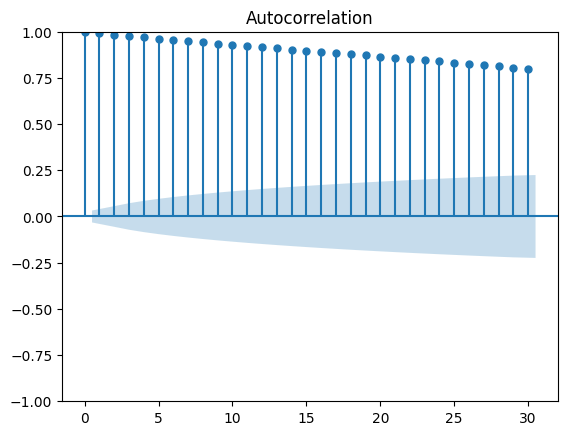

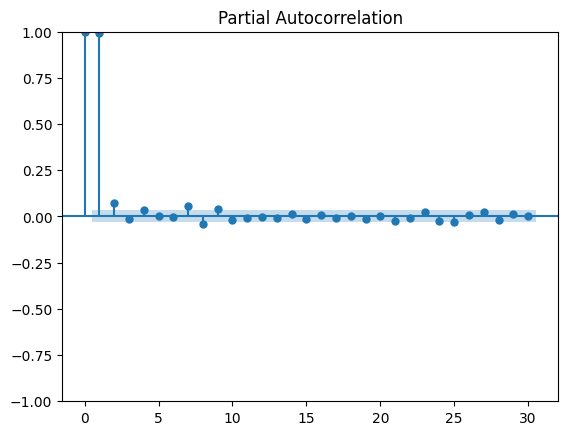

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(quad_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(quad_residuals, lags=30)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from scipy.special import comb
import statsmodels.api as sm
def sim_dataset(AR, MA, t=100, trend = None, polynomial_root = -0.5, MA_weight = 0.5):
  """
  Simulates a dataset given AR or MA order.
  Selects AR terms so that the polynomial root is the given value;
  as long as the root is within (-1, 1), the series will be stationary.
  """
  if trend is None:
    trend = lambda x: 0
  arparams = np.array([comb(AR, i)*(polynomial_root)**(i) for i in range(1, AR + 1)])
  maparams = np.array([MA_weight] * MA)
  ar = np.r_[1, arparams] # add zero-lag
  ma = np.r_[1, maparams] # add zero-lag
  arma_process = sm.tsa.ArmaProcess(ar, ma)
  print("ARMA process is stationary: ", arma_process.isstationary)
  print("ARMA process is invertible: ", arma_process.isinvertible)
  y = arma_process.generate_sample(t)
  y = np.array([_y + trend(j) for j, _y in enumerate(y)])
  return y

#### White noise
ACF: no clear pattern after first term
PACF: no clear pattern after first term

ARMA process is stationary:  True
ARMA process is invertible:  True


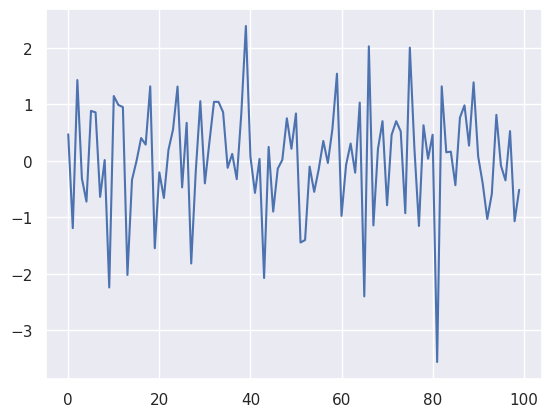

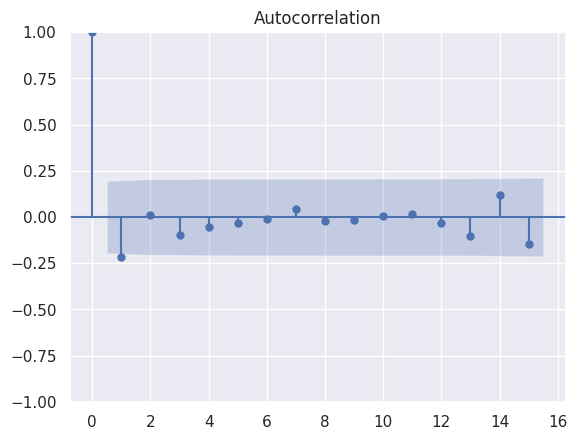

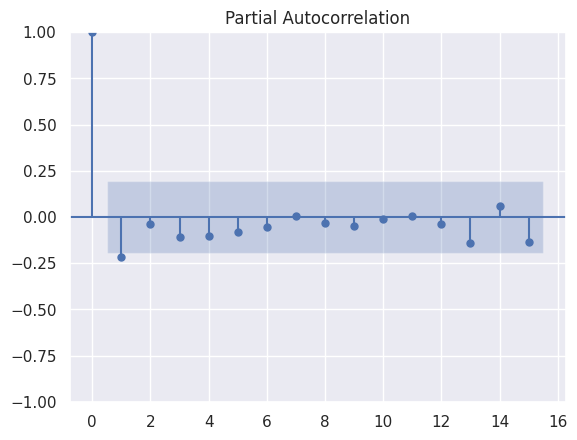

In [ ]:
np.random.seed(1234)
white_noise = sim_dataset(0, 0, 100)
plt.plot(white_noise)
plt.show()
sm.graphics.tsa.plot_acf(white_noise, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(white_noise, lags=15)
plt.show()

ARMA process is stationary:  True
ARMA process is invertible:  True


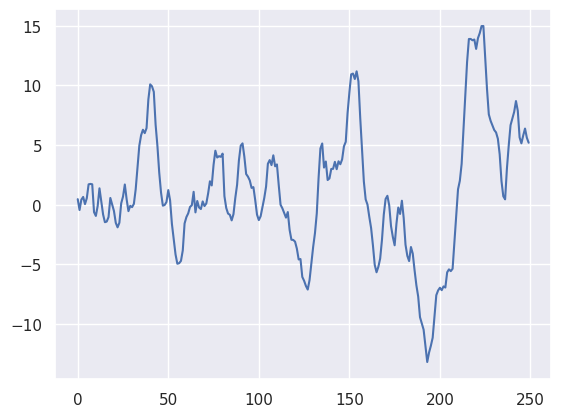

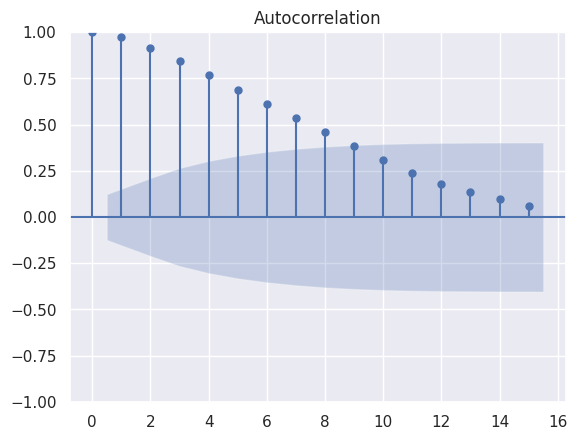

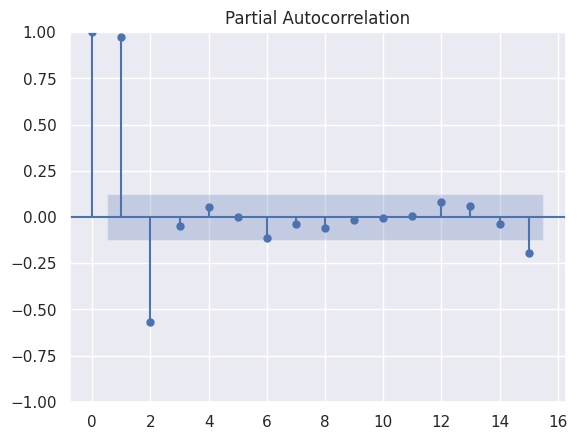

In [ ]:
np.random.seed(1234)
AR_series = sim_dataset(2, 0, 250, polynomial_root = -0.8)
plt.plot(AR_series)
plt.show()
sm.graphics.tsa.plot_acf(AR_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(AR_series, lags=15)
plt.show()

ARMA process is stationary:  True
ARMA process is invertible:  True


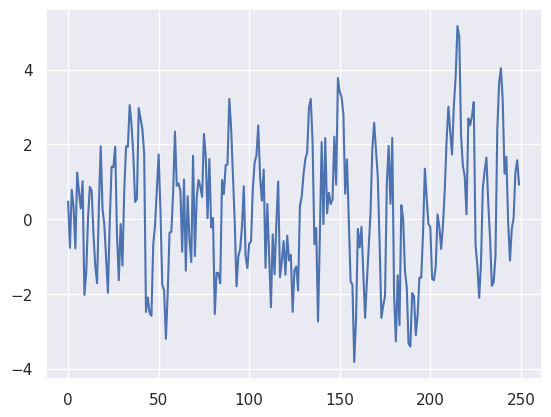

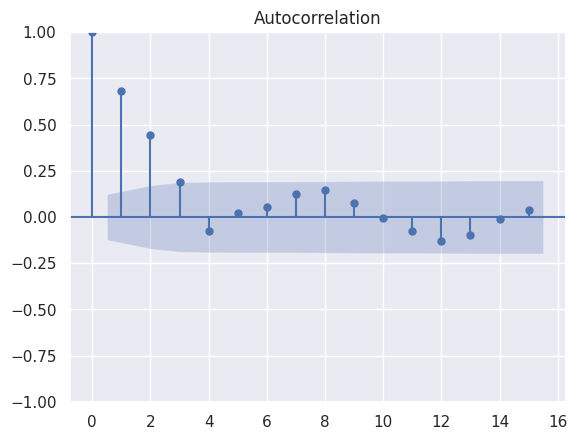

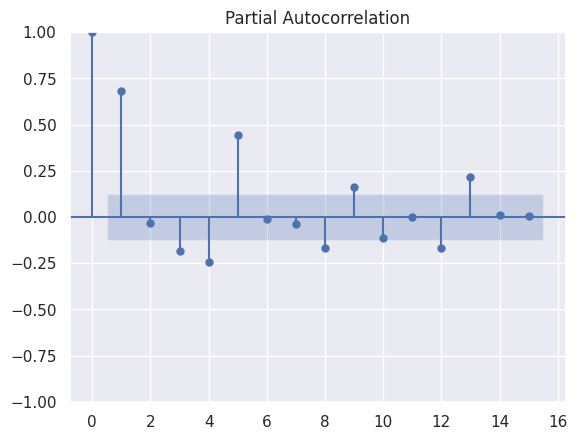

In [ ]:
np.random.seed(1234)
MA_series = sim_dataset(0, 3, 250, MA_weight=0.9)
plt.plot(MA_series)
plt.show()
sm.graphics.tsa.plot_acf(MA_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(MA_series, lags=15)
plt.show()

ARMA process is stationary:  True
ARMA process is invertible:  True


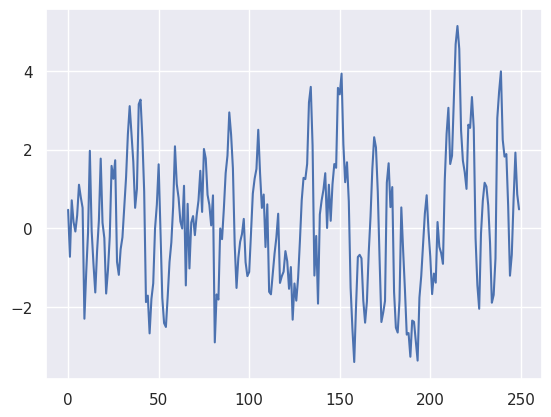

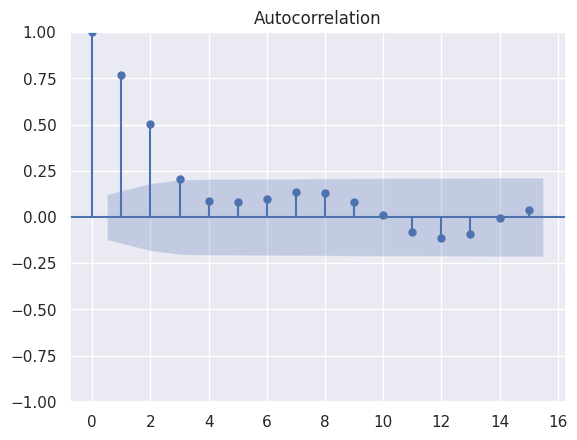

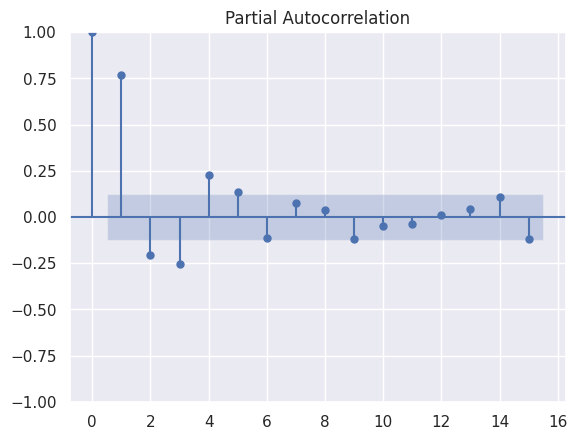

In [ ]:
np.random.seed(1234)
ARMA_series = sim_dataset(1, 2, 250, polynomial_root = -0.5)
plt.plot(ARMA_series)
plt.show()
sm.graphics.tsa.plot_acf(ARMA_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(ARMA_series, lags=15)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -351.516
Date:                Wed, 06 Dec 2023   AIC                            711.032
Time:                        07:10:12   BIC                            725.118
Sample:                             0   HQIC                           716.701
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2190      1.508      0.808      0.419      -1.737       4.175
ar.L1          1.5431      0.058     26.696      0.000       1.430       1.656
ar.L2         -0.5853      0.057    -10.249      0.0

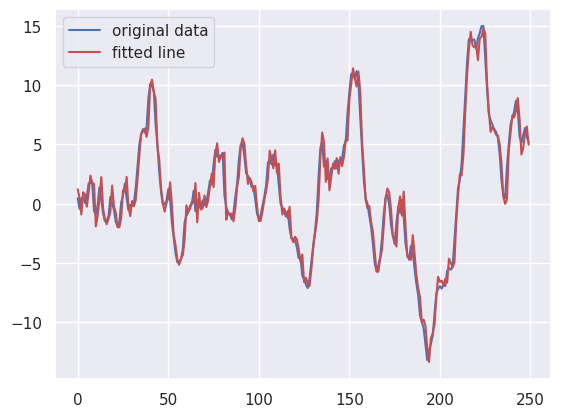

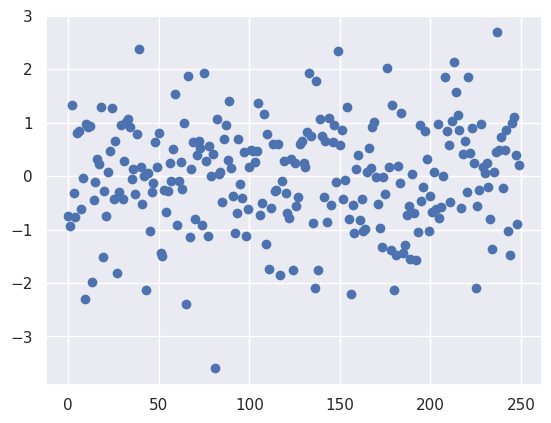

MSE with AR(1) model: 0.9632736339542407
AIC with AR(1) model: 706.1148265753319
BIC with AR(1) model: 716.6792093289187


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
AR_order = 2
ar_higher = ARIMA(AR_series, order=(AR_order, 0, 0)).fit()
print(ar_higher.summary())
ar_higher_predictions = ar_higher.predict()
ar_higher_residuals = AR_series - ar_higher_predictions
ar_higher_residuals = ar_higher_residuals # Fitting AR 1 model means removing one observation
plt.plot(AR_series, label='original data')
plt.plot(ar_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()
print("MSE with AR(1) model:", np.mean(ar_higher_residuals**2))
print("AIC with AR(1) model:", evaluate_AIC(AR_order + 1, ar_higher_residuals))
print("BIC with AR(1) model:", evaluate_BIC(AR_order + 1, ar_higher_residuals))

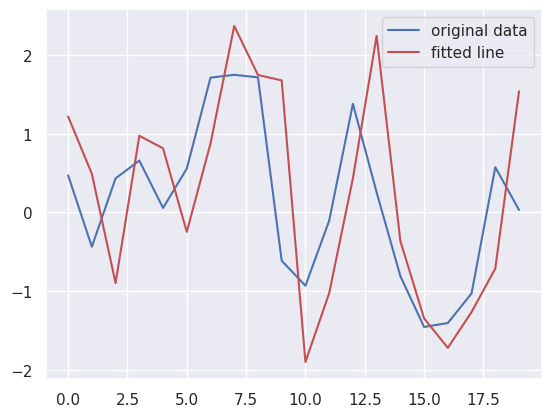

In [ ]:
plt.plot(AR_series[:20], label='original data')
plt.plot(ar_higher_predictions[:20], 'r', label='fitted line')
plt.legend()
plt.show()

In [ ]:
def grid_search_ARIMA(data, AR_range, MA_range, verbose=False):
  min_aic = np.inf
  min_bic = np.inf
  min_aic_index = None
  min_bic_index = None
  aic_matrix = np.zeros((len(AR_range), len(MA_range)))
  bic_matrix = np.zeros((len(AR_range), len(MA_range)))
  for AR_order in AR_range:
    for MA_order in MA_range:
      arma = ARIMA(data, order=(AR_order, 0, MA_order)).fit()
      aic_matrix[AR_order, MA_order] = arma.aic
      bic_matrix[AR_order, MA_order] = arma.bic
      if arma.aic < min_aic:
        min_aic = arma.aic
        min_aic_index = (AR_order, 0, MA_order)
      if arma.bic < min_bic:
        min_bic = arma.bic
        min_bic_index = (AR_order, 0, MA_order)
  if verbose:
    print("Minimizing AIC order: ", min_aic_index)
    print("Minimizing BIC order: ", min_bic_index )
    print("matrix of AIC", aic_matrix)
    print("Matrix of BIC", bic_matrix)
  return min_aic_index, min_bic_index, aic_matrix, bic_matrix


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Minimizing AIC order:  (2, 0, 0)
Minimizing BIC order:  (2, 0, 0)
matrix of AIC [[1553.78272918 1255.25060081 1057.21735204  914.82988836]
 [ 814.38492835  740.89378902  720.55623289  714.35754726]
 [ 711.03231248  712.86832543  714.07618607  715.90615242]
 [ 712.84223033  714.69648877  716.06319733  711.9076681 ]]
Matrix of BIC [[1560.82565102 1265.81498356 1071.30319571  932.43719295]
 [ 824.9493111   754.97963269  738.16353748  735.48631277]
 [ 725.11815616  730.47563002  735.20495158  740.55637885]
 [ 730.44953492  735.82525428  740.71342375  740.07935544]]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -351.516
Date:                Wed, 06 Dec 2023   AIC                            711.032
Time:                        07:10:39   BIC                            725.118
Sample:                             0

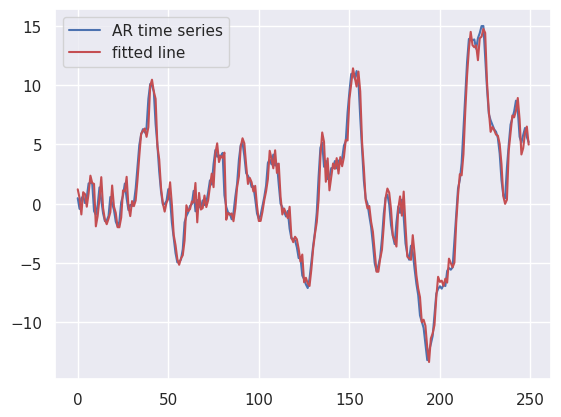

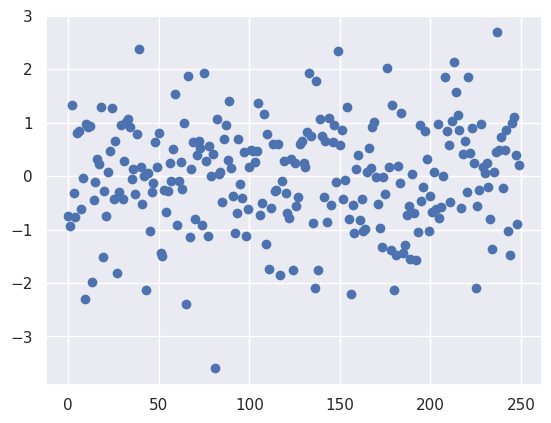

Automatic selection finds model with AR 2, MA 0
MSE with selected model: 0.9632736339542407


In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(AR_series, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(AR_series, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = AR_series - arma_predictions
  arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
  plt.plot(AR_series, label='AR time series')
  plt.plot(arma_predictions, 'r', label='fitted line')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

Minimizing AIC order:  (0, 0, 3)
Minimizing BIC order:  (0, 0, 3)
matrix of AIC [[986.90922409 862.24295047 841.89257746 705.22718413]
 [834.38150984 836.19113675 786.94256054 705.48427646]
 [836.09410819 810.27377651 762.1474896  707.46372658]
 [829.78701607 829.05395877 757.13459181 709.60497567]]
Matrix of BIC [[993.95214593 872.80733323 855.97842114 722.83448872]
 [844.9458926  850.27698042 804.54986513 726.61304196]
 [850.17995186 827.8810811  783.27625511 732.11395301]
 [847.39432066 850.18272428 781.78481824 737.77666302]]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -347.614
Date:                Wed, 06 Dec 2023   AIC                            705.227
Time:                        07:11:01   BIC                            722.834
Sample:                             0   HQIC                           712.314
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1543      0.252      0.613      0.540      -0.339       0.647
ma.L1          0.9240      0.034     27.025      0.000       0.857       0.991
ma.L2          0.9620      0.129      7.441      0.0

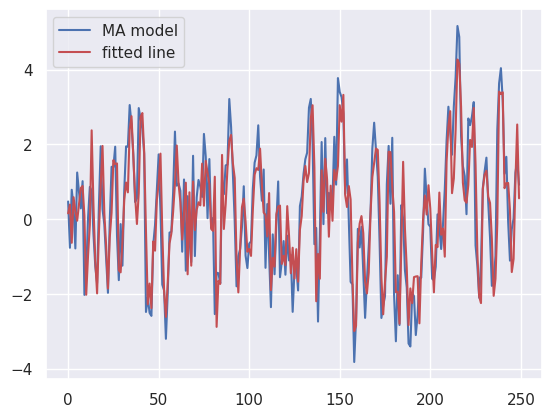

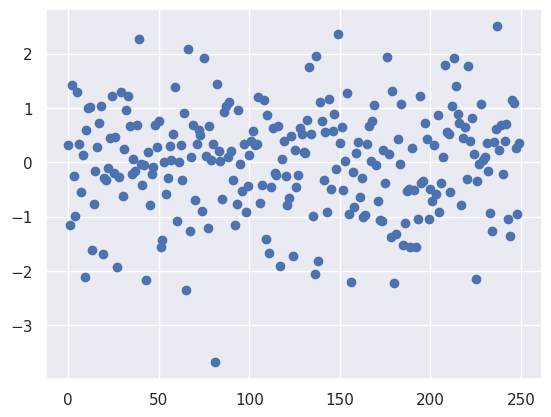

Automatic selection finds model with AR 0, MA 3
MSE with selected model: 0.9390644462157862


In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(MA_series, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(MA_series, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = MA_series - arma_predictions
  arma_residuals = arma_residuals
  plt.plot(MA_series, label='MA model')
  plt.plot(arma_predictions, 'r', label='fitted line')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Minimizing AIC order:  (1, 0, 2)
Minimizing BIC order:  (1, 0, 2)
matrix of AIC [[973.85586927 836.84084996 727.99939636 712.21420308]
 [755.1614623  750.89153123 709.47226897 711.46669608]
 [746.14093803 743.51132856 711.46698331 710.73467747]
 [731.98360613 728.5315214  713.45942566 714.42139704]]
Matrix of BIC [[980.89879111 847.40523272 742.08524003 729.82150767]
 [765.72584506 764.9773749  727.07957356 732.59546159]
 [760.2267817  761.11863315 732.59574881 735.38490389]
 [749.59091072 749.66028691 738.10965209 742.59308438]]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -349.736
Date:                Wed, 06 Dec 2023   AIC                            709.472
Time:                        07:11:42   BIC                            727.080
Sample:                             0   HQIC                         

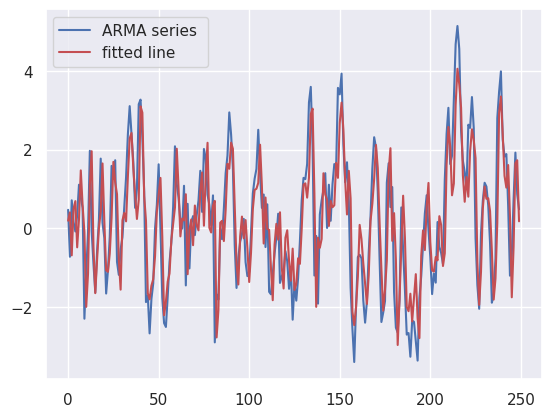

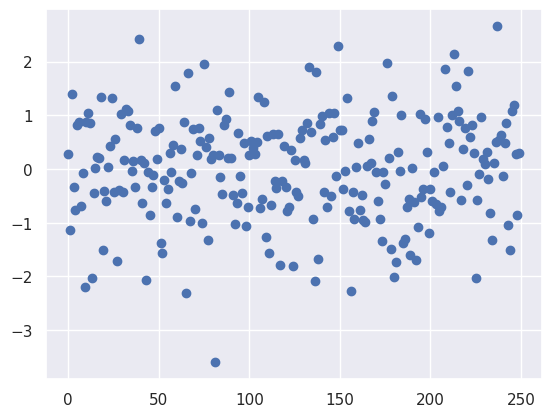

Automatic selection finds model with AR 1, MA 2
MSE with selected model: 0.957173618268086


In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(ARMA_series, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(ARMA_series, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = ARMA_series - arma_predictions
  arma_residuals = arma_residuals
  plt.plot(ARMA_series, label='ARMA series ')
  plt.plot(arma_predictions, 'r', label='fitted line')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

ARMA process is stationary:  True
ARMA process is invertible:  True


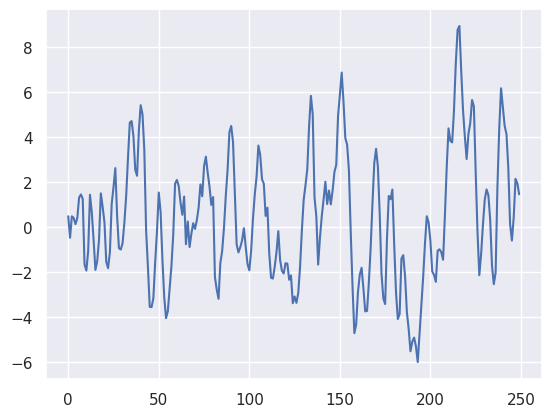

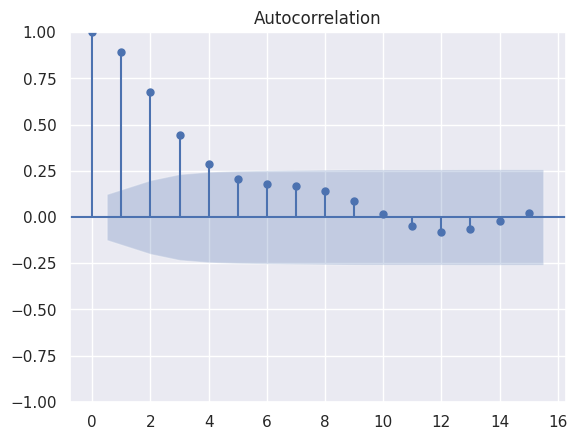

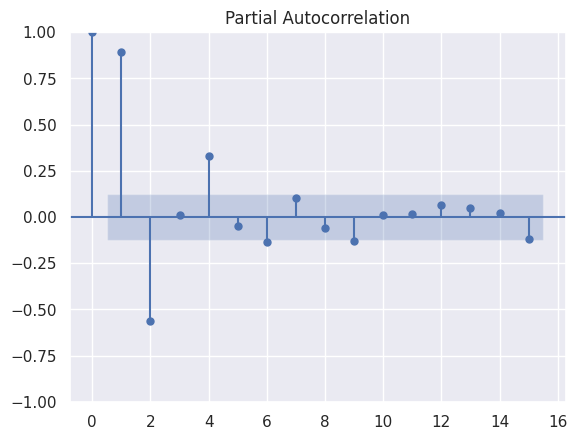

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Minimizing AIC order:  (2, 0, 2)
Minimizing BIC order:  (1, 0, 2)
matrix of AIC [[1230.177846    992.93279633  833.45884984  743.90285356]
 [ 837.93096778  778.1142701   714.1535879   712.37826363]
 [ 744.21977832  746.18666807  712.35419478  714.31986607]
 [ 746.14838714  744.09104363  714.32068092  715.78666861]]
Matrix of BIC [[1237.22076784 1003.49717909  847.54469351  761.51015815]
 [ 848.49535054  792.20011377  731.76089249  733.50702913]
 [ 758.30562199  763.79397266  733.48296029  738.97009249]
 [ 763.75569173  765.21980914  738.97090735  743.95835596]]
AIC, BIC do not agree.


In [ ]:
np.random.seed(1234)
ARMA_series_alt = sim_dataset(2, 2, 250, polynomial_root = -0.5)
plt.plot(ARMA_series_alt)
plt.show()
sm.graphics.tsa.plot_acf(ARMA_series_alt, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(ARMA_series_alt, lags=15)
plt.show()

min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(ARMA_series_alt, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(ARMA_series, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = ARMA_series - arma_predictions
  arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
  plt.plot(ARMA_series, label='ARMA series ')
  plt.plot(arma_predictions, 'r', label='fitted line')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -349.736
Date:                Wed, 06 Dec 2023   AIC                            709.472
Time:                        06:57:08   BIC                            727.080
Sample:                             0   HQIC                           716.559
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1964      0.224      0.878      0.380      -0.242       0.635
ar.L1          0.4084      0.088      4.652      0.000       0.236       0.581
ma.L1          0.5164      0.075      6.917      0.0

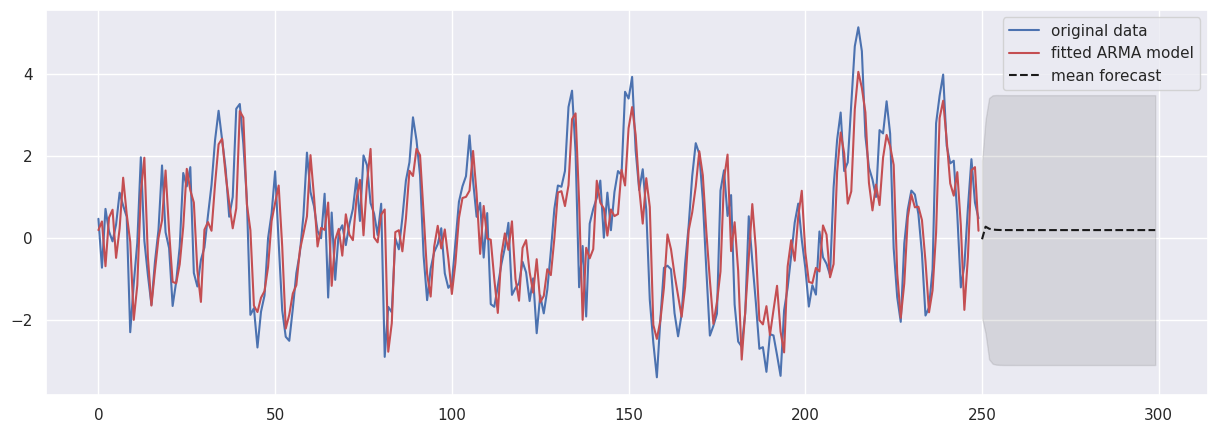

In [ ]:
arma = ARIMA(ARMA_series, order=min_bic_index).fit()
print(arma.summary())
arma_predictions = arma.predict()
fcast = arma.get_forecast(50).summary_frame()

fig, ax = plt.subplots(figsize=(15, 5))

arma_predictions = arma.predict()
ax.plot(np.arange(len(ARMA_series)), ARMA_series, label='original data')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(np.arange(len(ARMA_series)), predicted_values, 'r', label='fitted ARMA model')
forecast_means = fcast['mean'].values.reshape(-1,1)
forecast_x_vals = np.arange(len(ARMA_series), len(ARMA_series) + 50)
ax.plot(forecast_x_vals, forecast_means, 'k--', label='mean forecast')
ax.fill_between(forecast_x_vals, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();

[[ 1.30622404e-03 -1.85758157e-07]]


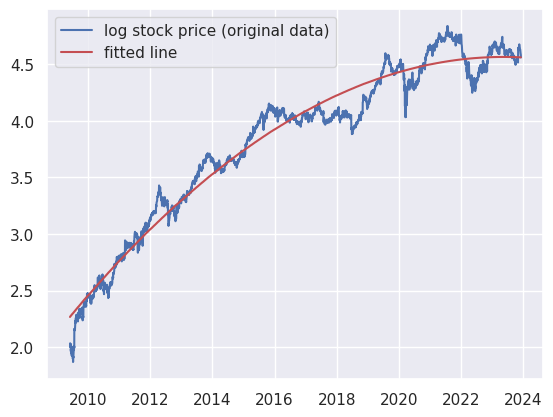

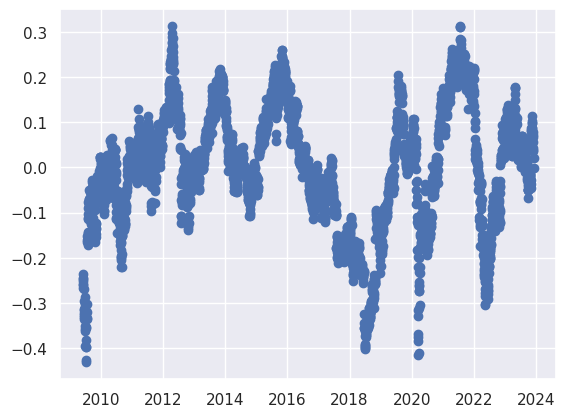

MSE with quadratic fit: 0.017681464026014098
AIC: -4372.355741159217
BIC: -4359.948038414849


In [ ]:
## After linear fit, it seems like a higher order model is needed
from sklearn import linear_model
clf = linear_model.LinearRegression()
index = fb_series.reset_index().index.values.reshape(-1,1)

new_x = np.hstack((index, index **2))
clf.fit(new_x, log_price)
print(clf.coef_) # To print the coefficient estimate of the series.
quad_prediction = clf.predict(new_x)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
quad_residuals = log_price - quad_prediction
plt.plot(date, quad_residuals, 'o')
plt.show();
print("MSE with quadratic fit:", np.mean((quad_residuals)**2))
print("AIC:", evaluate_AIC(2, quad_residuals))
print("BIC:", evaluate_BIC(2, quad_residuals))

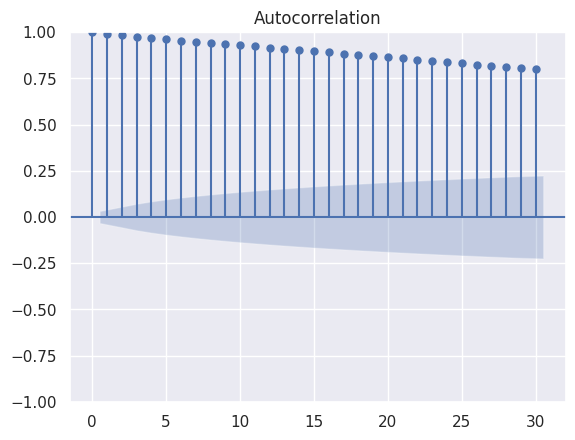

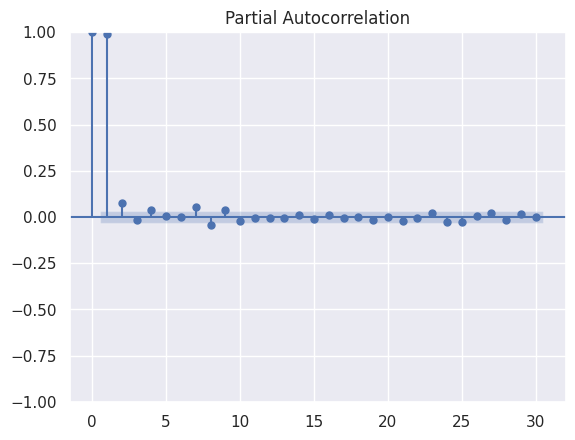

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(quad_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(quad_residuals, lags=30)
plt.show()

In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(quad_residuals, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(quad_residuals, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = quad_residuals - arma_predictions
  arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
  plt.plot(quad_residuals, label='Residuals from fitted quadratic line')
  plt.plot(arma_predictions, 'r', label='fitted ARMA process')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Minimizing AIC order:  (1, 0, 3)
Minimizing BIC order:  (2, 0, 0)
matrix of AIC [[ -4372.3557259   -8752.49982954 -11758.32127581 -13687.13714139]
 [-19303.47396428 -19325.32285123 -19324.96838213 -19330.47828405]
 [-19326.31161995 -19327.41746845 -19325.59747073 -19328.45383669]
 [-19326.02732494 -19325.52923173 -19326.79045153 -19326.9985199 ]]
Matrix of BIC [[ -4359.94802316  -8733.88827543 -11733.50587032 -13656.11788453]
 [-19284.86241017 -19300.50744574 -19293.94912527 -19293.25517582]
 [-19301.49621446 -19296.39821159 -19288.3743625  -19285.02687709]
 [-19295.00806807 -19288.3061235  -19283.36349193 -19277.36770892]]
AIC, BIC do not agree.


In [ ]:
train_test_split = int(len(price) * 0.8)
train_price, test_price = quad_residuals[:train_test_split], quad_residuals[train_test_split:]
train_date, test_date = date[:train_test_split], date[train_test_split:]
assert(len(train_date) + len(test_date) == len(date))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2924
Model:                 ARIMA(2, 0, 2)   Log Likelihood                7751.422
Date:                Wed, 06 Dec 2023   AIC                         -15490.844
Time:                        07:13:02   BIC                         -15454.959
Sample:                             0   HQIC                        -15477.919
                               - 2924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0135      0.035     -0.385      0.700      -0.082       0.055
ar.L1          0.5389      0.190      2.833      0.005       0.166       0.912
ar.L2          0.4495      0.189      2.376      0.0

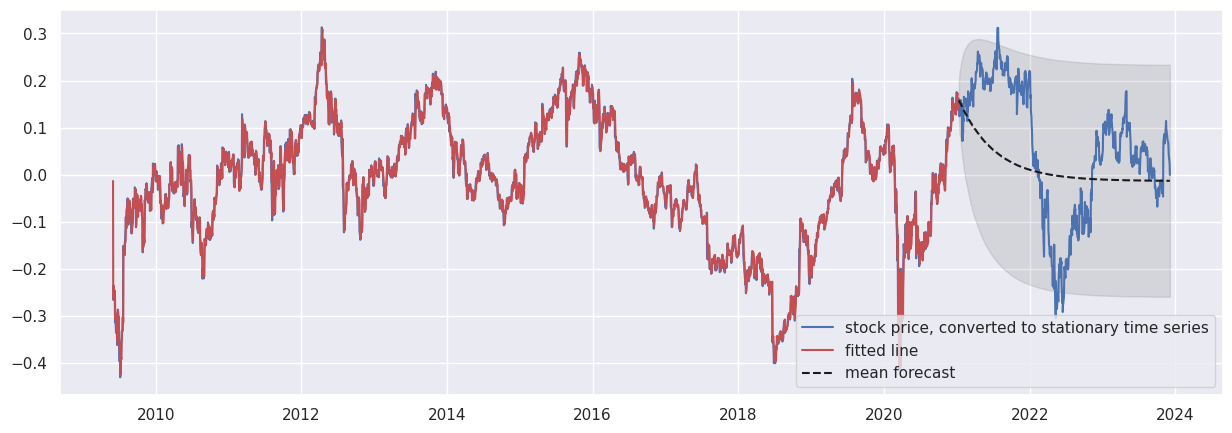

In [ ]:
## First, let's see how this does with the AIC selected values.
arma = ARIMA(train_price, order=min_aic_index).fit()
print(arma.summary())
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, quad_residuals, label='stock price, converted to stationary time series')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(train_date, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
test_set_mse = np.mean((forecast_means.reshape(test_price.shape) - test_price)**2)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();
print("Test set mean squared error: ", test_set_mse)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2924
Model:                 ARIMA(1, 0, 2)   Log Likelihood                7750.312
Date:                Wed, 06 Dec 2023   AIC                         -15490.624
Time:                        07:13:26   BIC                         -15460.721
Sample:                             0   HQIC                        -15479.854
                               - 2924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0135      0.035     -0.390      0.697      -0.081       0.054
ar.L1          0.9918      0.002    491.070      0.000       0.988       0.996
ma.L1         -0.0960      0.010     -9.243      0.0

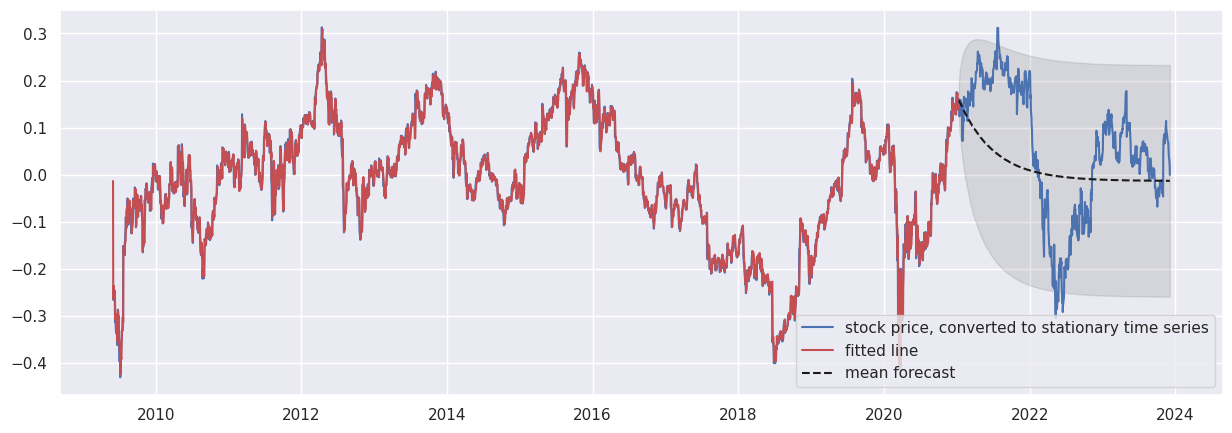

In [ ]:
## Now, let's see how this does with the BIC selected values.
arma = ARIMA(train_price, order=min_bic_index).fit()
print(arma.summary())
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, quad_residuals, label='stock price, converted to stationary time series')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(train_date, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
test_set_mse = np.mean((forecast_means.reshape(test_price.shape) - test_price)**2)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();
print("Test set mean squared error: ", test_set_mse)

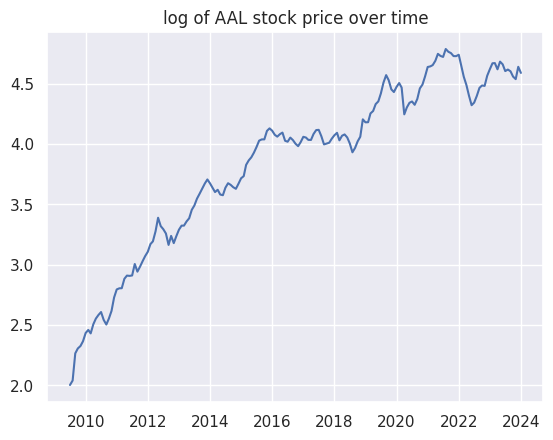

In [ ]:
collapsed = fb_series.groupby(pd.Grouper(freq ='M')).mean()
month_date = collapsed.reset_index().Date.dt.date.values.reshape(-1,1)
month_price = collapsed.High.values.reshape(-1,1)
month_log_price = np.log(month_price)
plt.plot(month_date, month_log_price)
plt.title("log of AAL stock price over time")
plt.show()

[[ 2.71297107e-02 -8.07580475e-05]]


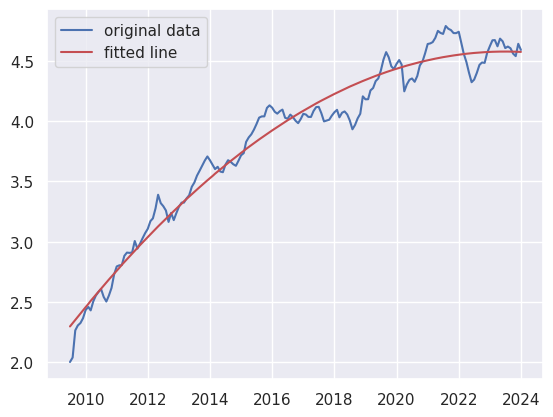

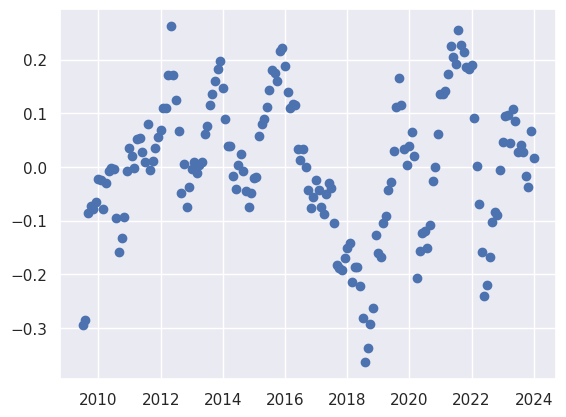

MSE with quadratic fit: 0.016398308159320002


In [ ]:
clf = linear_model.LinearRegression()
index = collapsed.reset_index().index.values.reshape(-1,1)
new_x = np.hstack((index, index **2))
clf.fit(new_x, month_log_price)
print(clf.coef_) # To print the coefficient estimate of the series.
month_quad_prediction = clf.predict(new_x)
plt.plot(month_date, month_log_price, label='original data')
plt.plot(month_date, month_quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
month_quad_residuals = month_log_price - month_quad_prediction
plt.plot(month_date, month_quad_residuals, 'o')
plt.show();
print("MSE with quadratic fit:", np.mean((month_quad_residuals)**2))

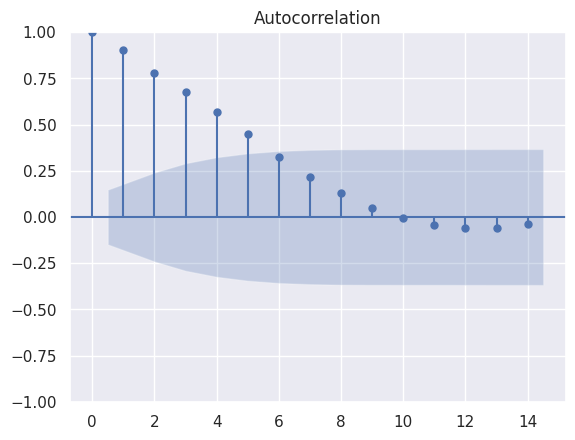

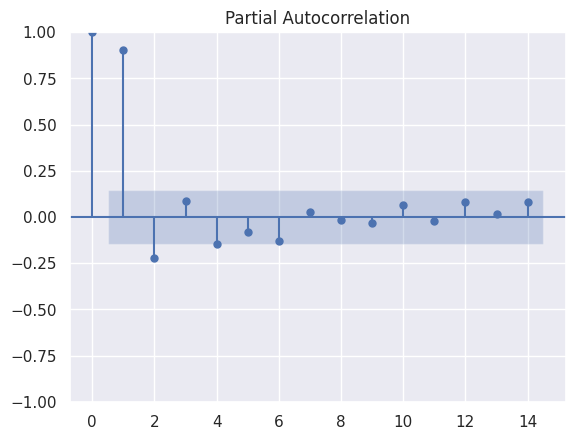

In [ ]:
sm.graphics.tsa.plot_acf(month_quad_residuals, lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(month_quad_residuals, lags=14)
plt.show()

In [ ]:
month_train_test = int(0.8 * len(month_date))
month_train, month_test = month_quad_residuals[:month_train_test], month_quad_residuals[month_train_test:]
month_date_train, month_date_test = month_date[:month_train_test], month_date[month_train_test:]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Minimizing AIC order:  (1, 0, 1)
Minimizing BIC order:  (1, 0, 1)
matrix of AIC [[-218.72250714 -387.62295975 -460.8193938  -502.91042053]
 [-540.92101808 -550.18179016 -548.19492927 -547.22224786]
 [-550.17471773 -548.18571103 -546.30918401 -549.84913213]
 [-548.17742373 -546.80827096 -545.61918736 -548.83843351]]
Matrix of BIC [[-212.39293519 -378.12860183 -448.1602499  -487.08649066]
 [-531.42666016 -537.52264626 -532.3709994  -528.23353202]
 [-537.51557383 -532.36178116 -527.32046817 -527.69563031]
 [-532.35349386 -527.81955512 -523.46568554 -523.52014572]]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  175
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 279.091
Date:                Wed, 06 Dec 2023   AIC                           -550.182
Time:                        07:14:21   BIC                           -537.523
Sample:                             0

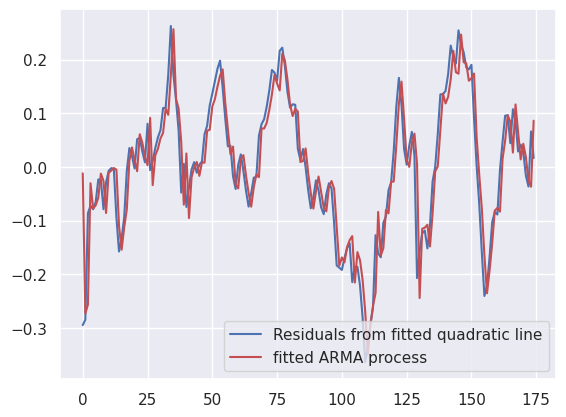

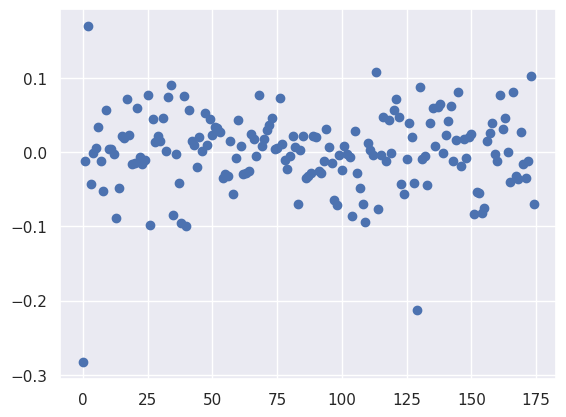

Automatic selection finds model with AR 1, MA 1
MSE with selected model: 0.0027784031619926246


In [ ]:
min_aic_index, min_bic_index, *other = grid_search_ARIMA(month_quad_residuals, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(month_quad_residuals, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = month_quad_residuals.reshape(arma_predictions.shape) - arma_predictions
  arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
  plt.plot(month_quad_residuals, label='Residuals from fitted quadratic line')
  plt.plot(arma_predictions, 'r', label='fitted ARMA process')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

Test set mean squared error:  0.014386569954082063
CSV file exported successfully: arma_forecast_results_neg.csv


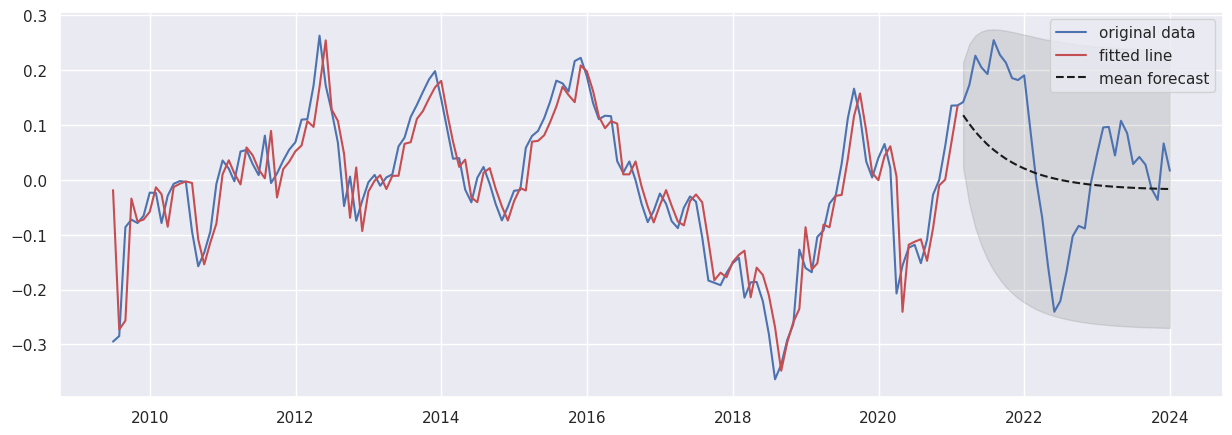

In [ ]:
arma = ARIMA(month_train, order=min_bic_index).fit()
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(month_test)).summary_frame()

arma_predictions = arma.predict()
ax.plot(month_date, month_quad_residuals, label='original data')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(month_date_train, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
ax.plot(month_date_test, forecast_means, 'k--', label='mean forecast')## dotted line
ax.fill_between(month_date_test.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();

test_set_mse = np.mean((forecast_means.reshape(month_test.shape) - month_test)**2)
print("Test set mean squared error: ", test_set_mse)

last_month_date = month_date[-len(forecast_means):]
last_month_date_flat = last_month_date.flatten()
forecast_means_flat = forecast_means.flatten()

# Create a DataFrame with only forecast means and last values of month_date
data = {
    'month_date': last_month_date_flat,
    'forecast_means': forecast_means_flat,
}

df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
csv_filename = 'arma_forecast_results_neg.csv'
df.to_csv(csv_filename, index=True)

print("CSV file exported successfully:", csv_filename)